In [13]:
import sys
sys.path.append("../")

import torch
import torchvision
from torch.utils.data import DataLoader

from mrl.encoders import resnet18, resnet50
from mrl.aug import get_inference_transforms

import warnings

warnings.filterwarnings("ignore")

In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
# IMAGE_SIZE = 192
IMAGE_SIZE = 96
transform = get_inference_transforms(image_size=(IMAGE_SIZE, IMAGE_SIZE))

train_ds = torchvision.datasets.STL10("../data/",
                                  split='train',
                                  transform=transform,
                                  download=True)
val_ds = torchvision.datasets.STL10("../data",
                                  split='test',
                                  transform=transform,
                                  download=True)

train_loader = DataLoader(train_ds,
                          batch_size=256,
                          num_workers=4)
val_loader = DataLoader(val_ds,
                       batch_size=256,
                       num_workers=4)

Files already downloaded and verified
Files already downloaded and verified


In [15]:
len(train_ds), len(val_ds)

(5000, 8000)

In [16]:
# ckpt = torch.load("../models/encoder.pth")
ckpt = torch.load("../models/encoder_resnet18_stl10_152k.pth")

model = resnet18()
# model = resnet50()
model.load_state_dict(ckpt)

model = model.eval().to(device)

In [17]:
from tqdm.auto import tqdm
import numpy as np

def get_embs_labels(dl, feature_dim, verbose):
    idx = 0
    embs, labels = [], []
    data = tqdm(dl) if verbose else dl
    for idx, (images, targets) in enumerate(data):
        with torch.no_grad():
            images = images.to(device)
            out = model(images)
            features = out.cpu().detach()
            features = features[:, :feature_dim]
            embs.extend(features.tolist())
            labels.extend(targets.cpu().detach().tolist())
    return np.array(embs), np.array(labels)

In [12]:
from sklearn.calibration import CalibratedClassifierCV
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report


def logistic_regression(feature_dim, verbose=False, pca=False):
    embeddings, labels = get_embs_labels(train_loader, feature_dim if not pca else 2048, verbose)
    embeddings_val, labels_val = get_embs_labels(val_loader, feature_dim if not pca else 2048, verbose)
    
    X_train, X_test = embeddings, embeddings_val
    y_train, y_test = labels, labels_val

    if verbose:
        print("train", X_train.shape[0], len(y_train))
        print("test", X_test.shape[0], len(y_test))
        print(embeddings.shape)
        print(labels.shape)
        print(embeddings_val.shape)
        print(labels_val.shape)
    
    clf = LogisticRegression(max_iter=100)
    clf = CalibratedClassifierCV(clf)

    if pca:
        pca = PCA(n_components=feature_dim)
        clf = Pipeline(steps=[('pca', pca), ('logistic', clf)])
    
    clf.fit(X_train, y_train)
    
    y_pred = clf.predict(X_test)
    
    acc = accuracy_score(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)
    class_report = classification_report(y_test, y_pred)
    

    print(f"Accuracy ({feature_dim}): ", acc)
    
    if verbose:
        print("Confusion matrix: \n", conf_matrix)
        print("Classification report: \n", class_report)
        
        y_pred_train = clf.predict(X_train)
        class_report = classification_report(y_train, y_pred_train)
        print("Classification report train: \n", class_report)

    return acc

In [9]:
logistic_regression(64, True)

100%|██████████| 32/32 [00:00<00:00, 45.99it/s]


train 5000 5000
test 8000 8000
(5000, 64)
(5000,)
(8000, 64)
(8000,)
Accuracy (64):  0.804
Confusion matrix: 
 [[745  23   3   4   1   1   1   0  16   6]
 [ 25 615   0  64   4  20   6  65   1   0]
 [  4   1 730   4   1   1   1   0   4  54]
 [  0  70   0 560  24  75   2  69   0   0]
 [  0  30   0  69 602  27  36  35   0   1]
 [  1  20   1 151  22 455  38 110   2   0]
 [  2   9   0  17  33  62 641  33   0   3]
 [  0  54   0  87  17  29   6 607   0   0]
 [ 17   0   1   4   0   0   0   0 769   9]
 [ 19   3  21   4   1   2   3   0  39 708]]
Classification report: 
               precision    recall  f1-score   support

           0       0.92      0.93      0.92       800
           1       0.75      0.77      0.76       800
           2       0.97      0.91      0.94       800
           3       0.58      0.70      0.63       800
           4       0.85      0.75      0.80       800
           5       0.68      0.57      0.62       800
           6       0.87      0.80      0.84       800


0.804

In [20]:
import math

FEATURE_DIM = 512

nesting_dims = [2**i for i in range(3, int(math.log2(FEATURE_DIM)) + 1)]
accs = []
for dim in nesting_dims:
    accs.append(logistic_regression(dim))

Accuracy (8):  0.671125
Accuracy (16):  0.76075
Accuracy (32):  0.79225
Accuracy (64):  0.804
Accuracy (128):  0.810625
Accuracy (256):  0.812375
Accuracy (512):  0.8155


In [19]:
import math

FEATURE_DIM = 512

nesting_dims = [2**i for i in range(3, int(math.log2(FEATURE_DIM)) + 1)]
accs_pca = []
for dim in nesting_dims:
    accs_pca.append(logistic_regression(dim, pca=True))

Accuracy (8):  0.612375
Accuracy (16):  0.737125
Accuracy (32):  0.7735
Accuracy (64):  0.8025
Accuracy (128):  0.806625
Accuracy (256):  0.806125
Accuracy (512):  0.807625


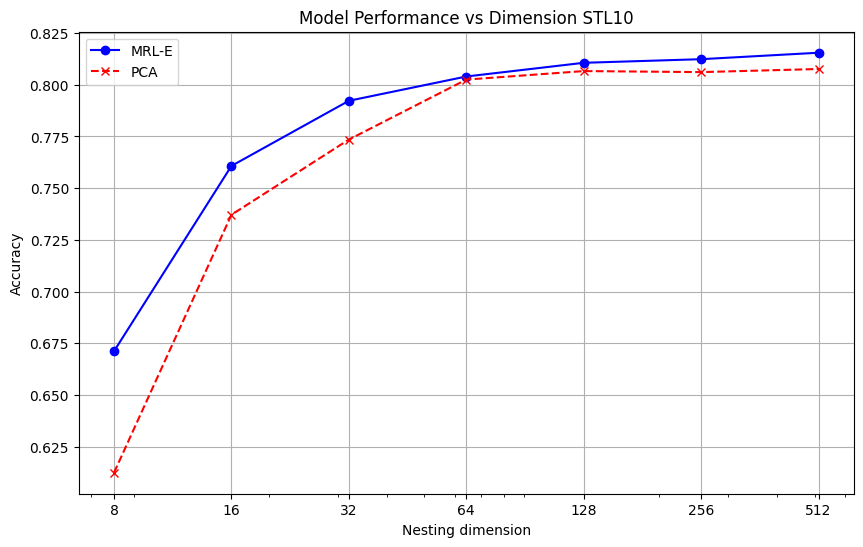

In [24]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(nesting_dims, accs, marker='o', linestyle='-', color='b', label="MRL-E")
plt.plot(nesting_dims, accs_pca, marker='x', linestyle='--', color='r', label='PCA')

plt.title('Model Performance vs Dimension STL10')
plt.xlabel('Nesting dimension')
plt.ylabel('Accuracy')

plt.xscale('log')
plt.xticks(nesting_dims, labels=[str(dim) for dim in nesting_dims])
plt.grid(True)

plt.legend()

plt.show()